In [1]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Create an engine to connect to your DuckDB database
engine = create_engine("duckdb:///olist.db")


In [3]:
# Load fact_sales table into a pandas DataFrame
df_sales = pd.read_sql("SELECT * FROM main_star.fact_sales", engine)
print(df_sales.head())


                           order_id  order_item_id  customer_key  product_key  \
0  5f79b5b0931d63f1a42989eb65b9da6e              1             1      12711.0   
1  a44895d095d7e0702b6a162fa2dbeced              1             2      16765.0   
2  5825ce2e88d5346438686b0bba99e5ee              1             4      22066.0   
3  0ab7fb08086d4af9141453c91878ed7a              1             5      17041.0   
4  cd3558a10d854487b4f907e9b326a4fc              1             6      31598.0   

   order_date_key order_purchase_timestamp   order_approved_at  \
0        20171114      2017-11-14 16:08:26 2017-11-14 16:35:32   
1        20170716      2017-07-16 09:40:32 2017-07-16 09:55:12   
2        20170816      2017-08-16 13:09:20 2017-08-17 03:10:27   
3        20180402      2018-04-02 13:42:17 2018-04-04 03:10:19   
4        20170412      2017-04-12 08:35:12 2017-04-12 08:50:12   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-11-17 15:32:08           2017-11-28 

In [4]:
print(df_sales.info())
print(df_sales.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110196 entries, 0 to 110195
Data columns (total 16 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       110196 non-null  object        
 1   order_item_id                  110196 non-null  int64         
 2   customer_key                   110196 non-null  int64         
 3   product_key                    108659 non-null  float64       
 4   order_date_key                 110196 non-null  int64         
 5   order_purchase_timestamp       110196 non-null  datetime64[ns]
 6   order_approved_at              110181 non-null  datetime64[ns]
 7   order_delivered_carrier_date   110195 non-null  datetime64[ns]
 8   order_delivered_customer_date  110196 non-null  datetime64[ns]
 9   order_estimated_delivery_date  110196 non-null  datetime64[ns]
 10  price                          110196 non-null  float64       
 11  

       month  total_sale_amount
0 2016-09-01             143.46
1 2016-10-01           47195.15
2 2016-12-01              19.62
3 2017-01-01          127482.37
4 2017-02-01          271239.32


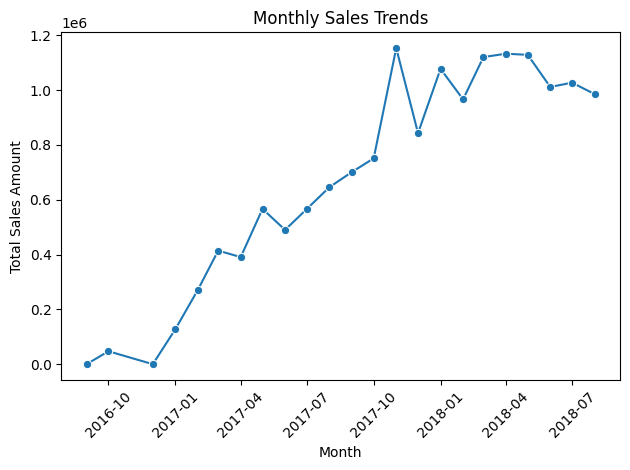

In [5]:
# Calculate Key Metrics

df_sales['order_purchase_timestamp'] = pd.to_datetime(df_sales['order_purchase_timestamp'])
df_sales['month'] = df_sales['order_purchase_timestamp'].dt.to_period('M').dt.to_timestamp()


monthly_sales = df_sales.groupby('month')['total_sale_amount'].sum().reset_index()
print(monthly_sales.head())


sns.lineplot(data=monthly_sales, x='month', y='total_sale_amount', marker='o')
plt.title("Monthly Sales Trends")
plt.xlabel("Month")
plt.ylabel("Total Sales Amount")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Index(['product_key', 'product_id', 'product_category', 'weight', 'length',
       'height', 'width'],
      dtype='object')
Index(['order_id', 'order_item_id', 'customer_key', 'product_key',
       'order_date_key', 'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'price', 'freight_value',
       'total_sale_amount', 'payment_type', 'total_installments',
       'total_payment_value', 'month', 'product_id', 'product_category',
       'weight', 'length', 'height', 'width'],
      dtype='object')
          product_category  total_sale_amount
11            beleza_saude         1412213.46
66      relogios_presentes         1264016.98
13         cama_mesa_banho         1225209.26
32           esporte_lazer         1118098.52
44  informatica_acessorios         1032603.65
54        moveis_decoracao          880329.92
72   utilidades_domesticas          758392.25
26              cool

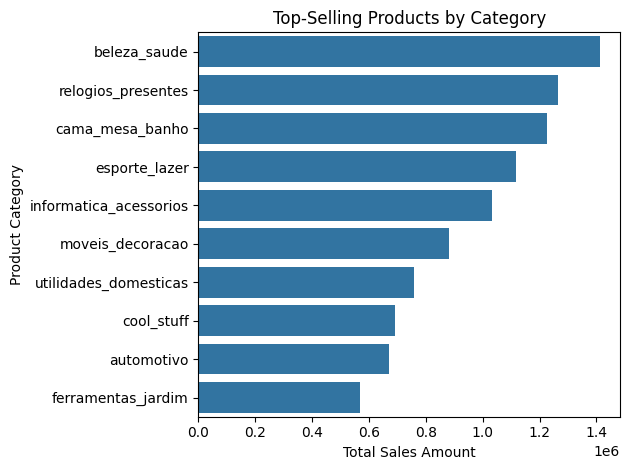

In [6]:
# Top-Selling Products
df_products = pd.read_sql("SELECT * FROM main_star.dim_product", engine)
print(df_products.columns)

df_sales_products = df_sales.merge(df_products, on='product_key', how='left')
print(df_sales_products.columns)

top_products = (
    df_sales_products
    .groupby('product_category')['total_sale_amount']
    .sum()
    .reset_index()
    .sort_values(by='total_sale_amount', ascending=False)
    .head(10)
)
print(top_products)

sns.barplot(data=top_products, x='total_sale_amount', y='product_category')
plt.title("Top-Selling Products by Category")
plt.xlabel("Total Sales Amount")
plt.ylabel("Product Category")
plt.tight_layout()
plt.show()

   customer_key  total_sale_amount segment
0             1             114.74  Medium
1             2              67.41     Low
2             3             195.42  Medium
3             4             179.35  Medium
4             5             107.01  Medium


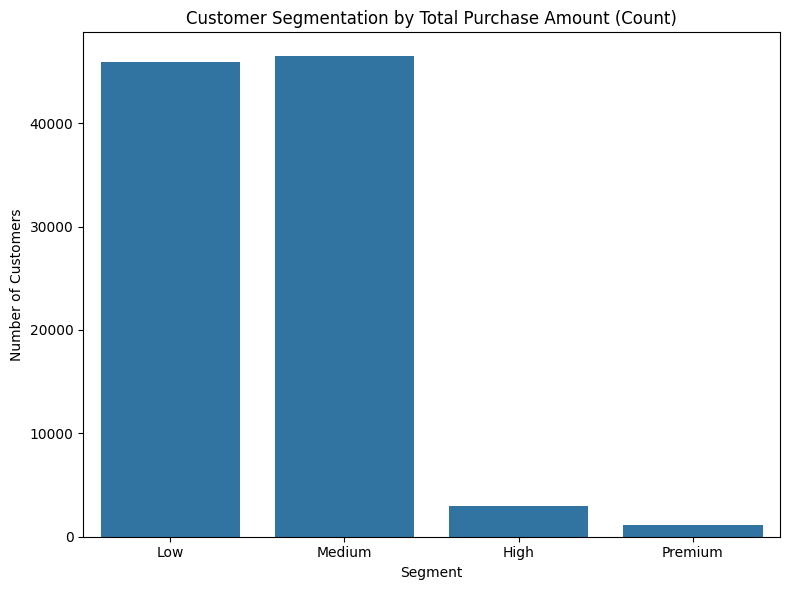

C:\Users\hugoa\AppData\Local\Temp\ipykernel_6664\2170174092.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_sales = customer_sales.groupby('segment')['total_sale_amount'].sum().reset_index()


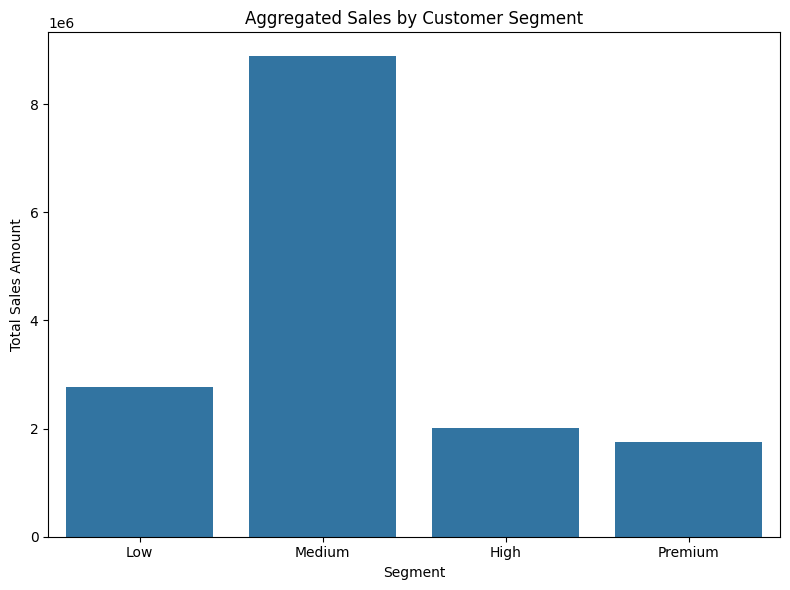

In [8]:
# Customer Segmentation by Purchase Behavior with Aggregated Sales

# Compute total sales per customer
customer_sales = df_sales.groupby('customer_key')['total_sale_amount'].sum().reset_index()

# Define segmentation bins and labels
bins = [0, 100, 500, 1000, float('inf')]
labels = ['Low', 'Medium', 'High', 'Premium']
customer_sales['segment'] = pd.cut(customer_sales['total_sale_amount'], bins=bins, labels=labels)

# Display first few rows to verify segmentation
print(customer_sales.head())

# Plot 1: Count of customers per segment
plt.figure(figsize=(8, 6))
sns.countplot(data=customer_sales, x='segment', order=labels)
plt.title("Customer Segmentation by Total Purchase Amount (Count)")
plt.xlabel("Segment")
plt.ylabel("Number of Customers")
plt.tight_layout()
plt.show()

# Compute total aggregated sales per segment
segment_sales = customer_sales.groupby('segment')['total_sale_amount'].sum().reset_index()

# Plot 2: Total aggregated sales per customer segment
plt.figure(figsize=(8, 6))
sns.barplot(data=segment_sales, x='segment', y='total_sale_amount', order=labels)
plt.title("Aggregated Sales by Customer Segment")
plt.xlabel("Segment")
plt.ylabel("Total Sales Amount")
plt.tight_layout()
plt.show()


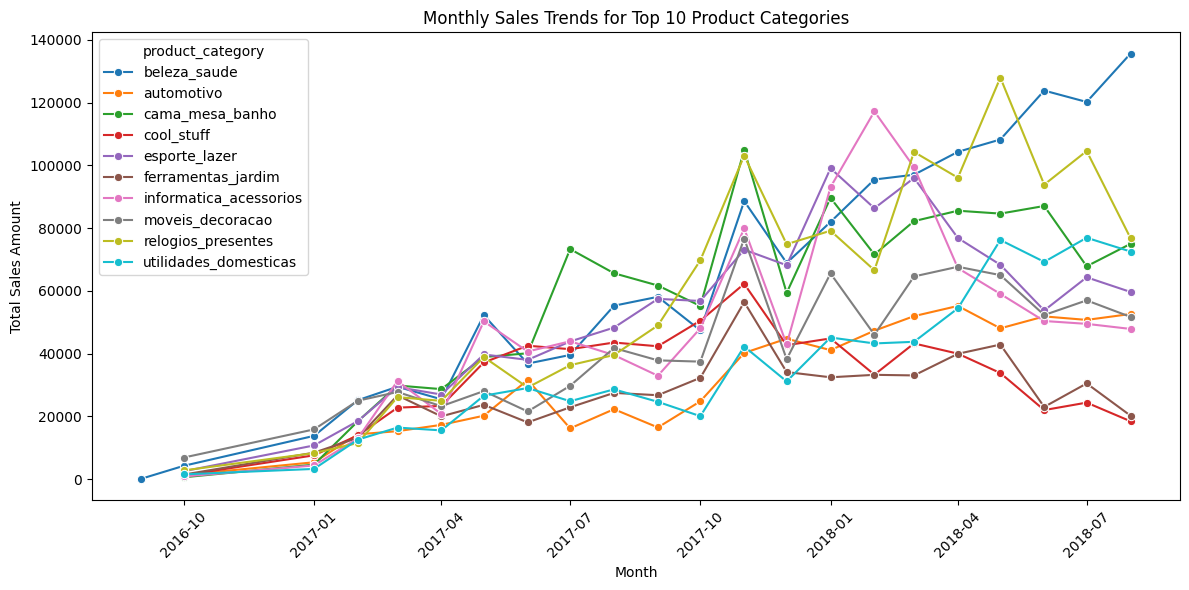

In [10]:
# Monthly Sales Trends for Top 10 Product Categories

# Load fact_sales and dim_product data
df_sales = pd.read_sql("SELECT * FROM main_star.fact_sales", engine)
df_products = pd.read_sql("SELECT * FROM main_star.dim_product", engine)

# Ensure the purchase timestamp is datetime and extract the month
df_sales['order_purchase_timestamp'] = pd.to_datetime(df_sales['order_purchase_timestamp'])
df_sales['month'] = df_sales['order_purchase_timestamp'].dt.to_period('M').dt.to_timestamp()

# Merge with product dimension to get the product category
df_sales_products = df_sales.merge(df_products, on='product_key', how='left')

# Aggregate total sales by month and product category
monthly_category_sales = (
    df_sales_products
    .groupby(['month', 'product_category'])['total_sale_amount']
    .sum()
    .reset_index()
)

# Identify the top ten categories by overall sales
top_categories = (
    monthly_category_sales.groupby('product_category')['total_sale_amount']
    .sum()
    .reset_index()
    .sort_values(by='total_sale_amount', ascending=False)
    .head(10)['product_category']
    .tolist()
)

# Filter the monthly data to only include the top ten categories
top_monthly_sales = monthly_category_sales[monthly_category_sales['product_category'].isin(top_categories)]

# Plot the trends for the top ten categories
plt.figure(figsize=(12, 6))
sns.lineplot(data=top_monthly_sales, x='month', y='total_sale_amount', hue='product_category', marker='o')
plt.title("Monthly Sales Trends for Top 10 Product Categories")
plt.xlabel("Month")
plt.ylabel("Total Sales Amount")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\hugoa\AppData\Local\Temp\ipykernel_6664\1877152416.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_freight_by_state, x='state', y='freight_value', palette="coolwarm")


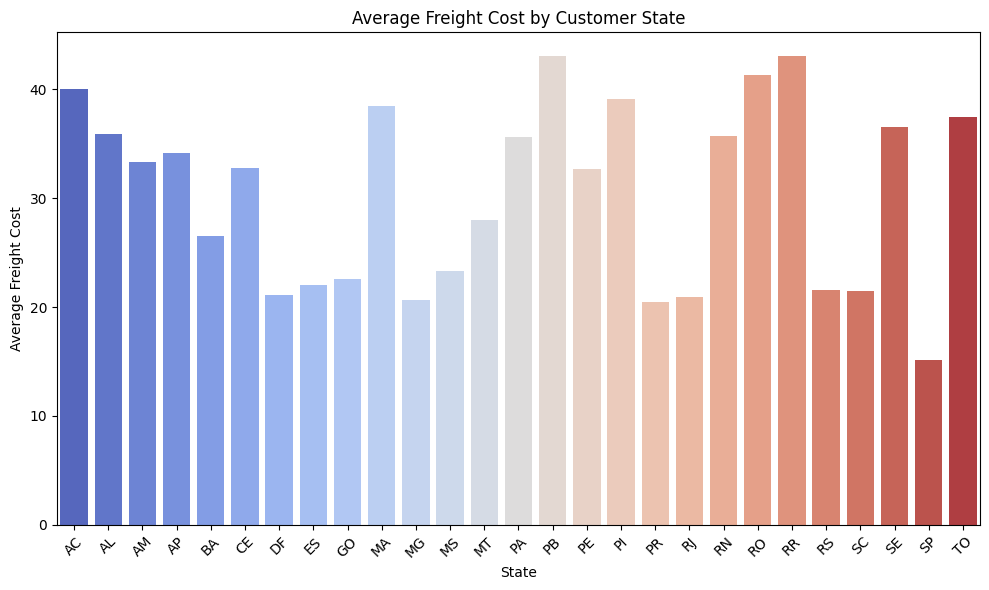

In [11]:
# Average Freight Cost by Customer State
# Load fact_sales and dim_customer data
df_sales = pd.read_sql("SELECT * FROM main_star.fact_sales", engine)
df_customers = pd.read_sql("SELECT * FROM main_star.dim_customer", engine)

# Merge sales with customer data on the surrogate key (assumed to be 'customer_key')
df_sales_customers = df_sales.merge(df_customers, on='customer_key', how='left')

# Calculate the average freight cost for each state
avg_freight_by_state = (
    df_sales_customers
    .groupby('state')['freight_value']
    .mean()
    .reset_index()
)

# Plot the average freight cost
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_freight_by_state, x='state', y='freight_value', palette="coolwarm")
plt.title("Average Freight Cost by Customer State")
plt.xlabel("State")
plt.ylabel("Average Freight Cost")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


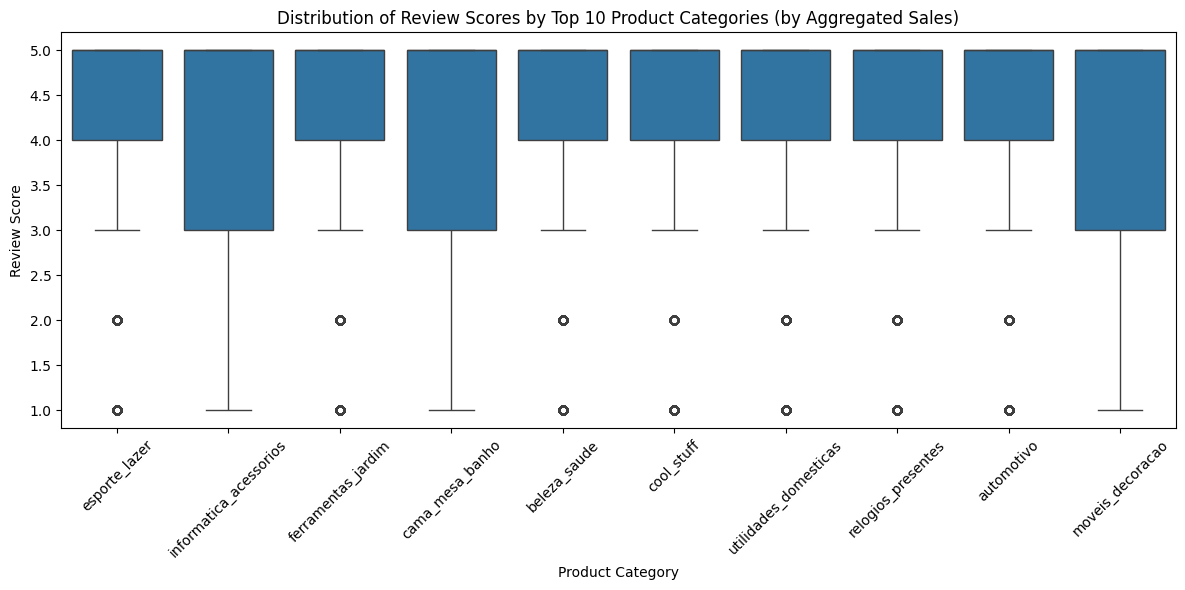

In [13]:
# Distribution of Review Scores by Top 10 Product Categories (by Aggregated Sales)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load fact_reviews, fact_sales (including aggregated sales), and dim_product data
df_reviews = pd.read_sql("SELECT * FROM main_star.fact_reviews", engine)
df_sales = pd.read_sql("SELECT order_id, product_key, total_sale_amount FROM main_star.fact_sales", engine)
df_products = pd.read_sql("SELECT * FROM main_star.dim_product", engine)

# Compute aggregated sales by product category
df_sales_products = df_sales.merge(df_products, on='product_key', how='left')
category_sales = (
    df_sales_products.groupby('product_category')['total_sale_amount']
    .sum()
    .reset_index()
)
top_categories = category_sales.sort_values(by='total_sale_amount', ascending=False).head(10)['product_category'].tolist()

# Merge reviews with sales on order_id, then join with product dimension for product_category
df_reviews_sales = df_reviews.merge(df_sales, on='order_id', how='left')
df_reviews_sales = df_reviews_sales.merge(df_products, on='product_key', how='left')

# Filter to include only rows with product_category in the top 10 categories
df_reviews_sales_top = df_reviews_sales[df_reviews_sales['product_category'].isin(top_categories)]

# Plot a boxplot of review scores by product category
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_reviews_sales_top, x='product_category', y='review_score')
plt.title("Distribution of Review Scores by Top 10 Product Categories (by Aggregated Sales)")
plt.xlabel("Product Category")
plt.ylabel("Review Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [14]:
import pandas as pd
from sqlalchemy import create_engine

engine = create_engine("duckdb:///olist.db")
tables = pd.read_sql("SHOW TABLES;", engine)
print(tables)


             name
0       customers
1     geolocation
2     order_items
3  order_payments
4   order_reviews
5          orders
6        products
7         sellers


C:\Users\hugoa\AppData\Local\Temp\ipykernel_6664\3620076805.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_order_value_by_payment, x='payment_type', y='total_sale_amount', palette="viridis")


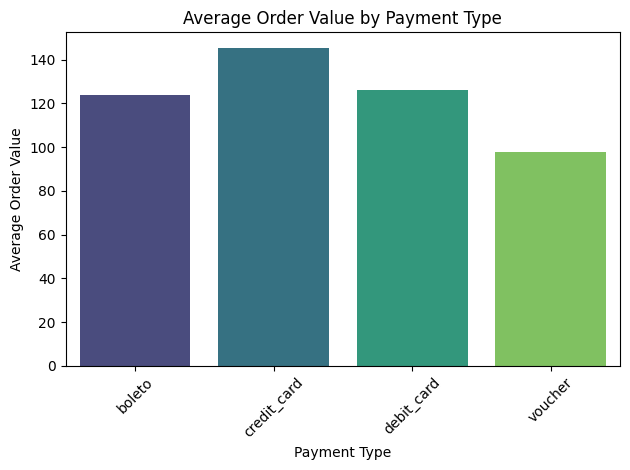

In [15]:
# Payment Type vs. Average Order Value
# Load fact_sales and fact_payments (adjust table name/columns as needed)
# Assuming fact_sales has a 'payment_type' column
df_sales = pd.read_sql("SELECT order_id, total_sale_amount, payment_type FROM main_star.fact_sales", engine)

avg_order_value_by_payment = (
    df_sales.groupby('payment_type')['total_sale_amount']
    .mean()
    .reset_index()
)

sns.barplot(data=avg_order_value_by_payment, x='payment_type', y='total_sale_amount', palette="viridis")
plt.title("Average Order Value by Payment Type")
plt.xlabel("Payment Type")
plt.ylabel("Average Order Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



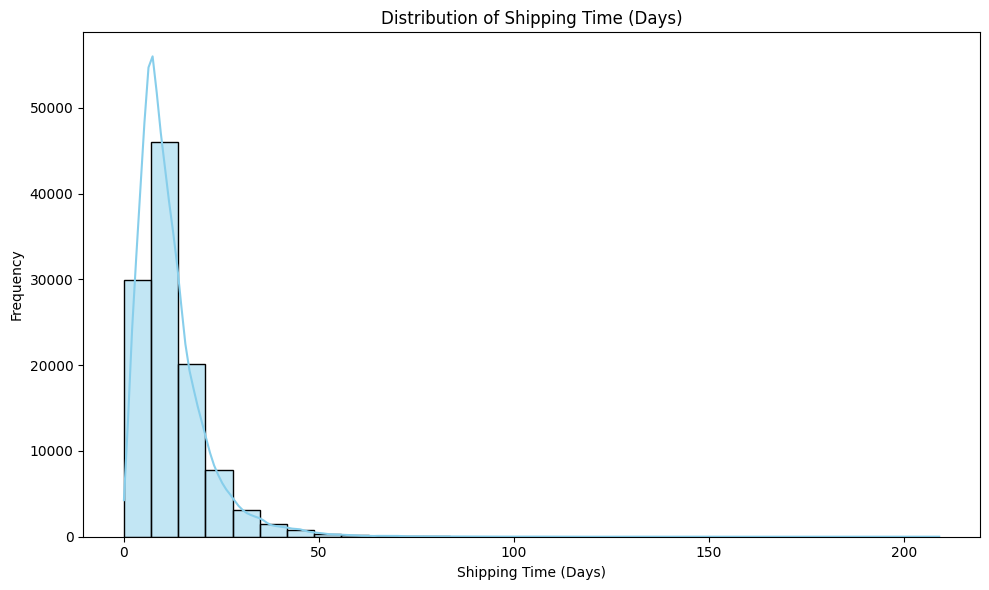

In [16]:
# Shipping Time Analysis
# Load fact_sales data
df_sales = pd.read_sql("SELECT * FROM main_star.fact_sales", engine)

# Convert timestamps to datetime
df_sales['order_purchase_timestamp'] = pd.to_datetime(df_sales['order_purchase_timestamp'])
df_sales['order_delivered_customer_date'] = pd.to_datetime(df_sales['order_delivered_customer_date'])

# Calculate shipping time in days
df_sales['shipping_time_days'] = (df_sales['order_delivered_customer_date'] - df_sales['order_purchase_timestamp']).dt.days

# Plot a histogram of shipping times
plt.figure(figsize=(10, 6))
sns.histplot(df_sales['shipping_time_days'].dropna(), bins=30, kde=True, color='skyblue')
plt.title("Distribution of Shipping Time (Days)")
plt.xlabel("Shipping Time (Days)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()
